# Byesian model reduction for neural networks

Here we will utilise a shallow neural network, to test how Bayesian priors over weights influence the classification performance. A shellow neural network cosnist of a single hidden layer and an output mapped to image labels via a categorical likelihood. We can write the generative model as 
\begin{equation}
    \prod_{n=1}^N p\left(l_n| \pmb{X}_n, \pmb{\Theta}\right) = \prod_{n=1}^N \prod_{k=1}^K \rho_{n,k}^{\delta_{k,l_n}}
\end{equation}
where $\pmb{\Theta} = \left(\pmb{W_1}, \ldots, \pmb{W}_L \right)$, and
$$ \rho_{n,k} = s_{\max}\left(\pmb{W}_L \cdot [\pmb{f}(\pmb{W}, \pmb{X}_n); 1] \right)$$

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [2]:
import jax.numpy as jnp
from jax import random, vmap, nn, lax, devices, device_put
from jax.nn import one_hot
import matplotlib.pyplot as plt
import seaborn as sns

print(devices('gpu'))
rng_key = random.PRNGKey(0)

[StreamExecutorGpuDevice(id=0, process_index=0), StreamExecutorGpuDevice(id=1, process_index=0)]


In [3]:
from numpyro import sample, param, handlers, prng_key
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
from numpyro.infer.autoguide import AutoNormal, AutoDelta
from numpyro.optim import optax_to_numpyro
import optax

import equinox as eqx
from numpyro import module, param, handlers, plate, subsample, sample, deterministic
import numpyro.distributions as dist

from functools import partial

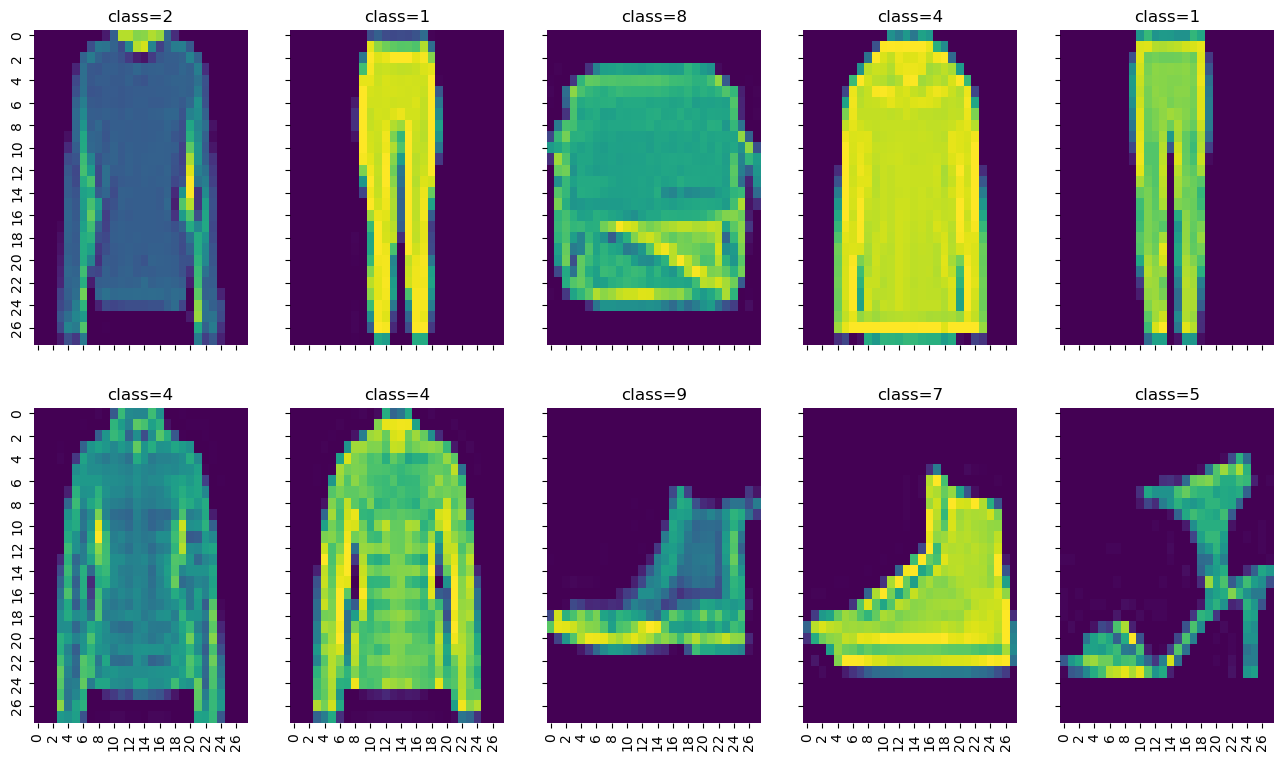

In [4]:
from numpc.datasets import load_data

# load data
train_ds, test_ds = load_data('fashion_mnist')
fig, axes = plt.subplots(2, 5, figsize=(16, 9), sharex=True, sharey=True)

for n in range(5):
    sns.heatmap(train_ds['image'][n].squeeze(), cmap='viridis', ax = axes[0, n], cbar=False, vmax=1., vmin=0.)
    axes[0, n].set_title('class={}'.format(train_ds['label'][n]))
    sns.heatmap(test_ds['image'][n].squeeze(), cmap='viridis', ax = axes[1, n], cbar=False, vmax=1., vmin=0.)
    axes[1, n].set_title('class={}'.format(test_ds['label'][n]))


train_ds['image'] = train_ds['image'].squeeze().reshape(train_ds['image'].shape[0], -1)
test_ds['image'] = test_ds['image'].squeeze().reshape(test_ds['image'].shape[0], -1)

_, in_size = train_ds['image'].shape
out_size = len(jnp.unique(train_ds['label']))

# number of neurons in hidden layer
num_hn = [10, 20, 40, 60, 80, 100, 200]

In [5]:
def register_network_parameters(nnet):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        new_lv = ()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                new_lv += (param(f'layer{l}.{name}', value),)
            else:
                new_lv += (value,)

        new_vals.append( layer.tree_unflatten(l_aux, new_lv) )

    vals = (new_vals,) + vals[1:]
    params = params.tree_unflatten(aux, vals)

    return eqx.combine(params, static)


def likelihood(nnet, images, labels, subsample_size, sigma):
    n, _ = images.shape

    with plate("n", n, subsample_size=subsample_size):
        batch_x = subsample(images, event_dim=1)
        pred = nnet(batch_x)
        
        if labels is not None:
            batch_y = nn.one_hot(subsample(labels, event_dim=0), out_size)
        else:
            batch_y = None
        
        sample(
            "obs", dist.Normal(pred, sigma).to_event(1), obs=batch_y
        )


def model(nnet, images, sigma=1, labels=None, subsample_size=None):
    nnet = vmap(register_network_parameters(nnet))
    likelihood(nnet, images, labels, subsample_size, sigma)


def test_model(rng_key, model, params, nnet, images, labels, guide=None, num_samples=1):
    pred = Predictive(model, guide=guide, params=params, num_samples=num_samples)

    n, _ = images.shape
    sample = pred(rng_key, nnet, images, sigma=1e-6)

    _labels = sample['obs'].argmax(-1)
    if num_samples > 1:
        acc = jnp.mean(_labels == labels, -1)
        print(acc.mean(), acc.std())
    else:
        print( jnp.mean(_labels == labels) )


with handlers.seed(rng_seed=0):
    for nh in num_hn:
        dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=1, activation=nn.swish, key=random.PRNGKey(0))
        model(dense_net, train_ds['image'], labels=train_ds['label'])


1 200


100%|██████████| 200000/200000 [04:29<00:00, 743.05it/s, init loss: 583726.7500, avg. loss [190001-200000]: 553645.0625]


0.8953
3 200


100%|██████████| 200000/200000 [06:32<00:00, 509.95it/s, init loss: 581579.1250, avg. loss [190001-200000]: 551546.6250]


0.8915


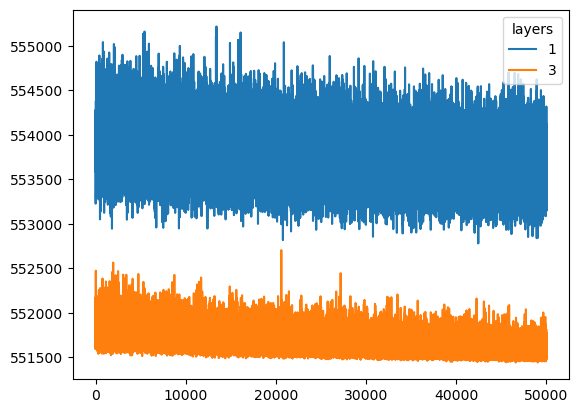

In [6]:
def guide(*args, **kwargs):
        pass

rng_key = random.PRNGKey(0)

for nh in num_hn[-1:]:
        for depth in range(1, 4, 2):
                print(depth, nh)
                rng_key, _rng_key = random.split(rng_key)
                dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

                optimizer = optax_to_numpyro(optax.adabelief(1e-4))
                svi = SVI(model, guide, optimizer, Trace_ELBO())

                rng_key, _rng_key = random.split(rng_key)
                results = svi.run(_rng_key, 200000, dense_net, train_ds['image'], labels=train_ds['label'], subsample_size=256);

                rng_key, _rng_key = random.split(rng_key)
                test_model(rng_key, model, results.params, dense_net, test_ds['image'], test_ds['label'])

                plt.plot(results.losses[-50000:], label=depth)

plt.legend(title="layers");

In [18]:
def register_random_network_parameters(nnet):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        new_lv = ()
        # c_sqr = sample(f'layer{l}.c^2', dist.InverseGamma(3, 20))
        c = 1. # jnp.sqrt(c_sqr)
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    new_lv += (sample(f'layer{l}.{name}', dist.Normal(0., 1.).expand(list(value.shape)).to_event(1)),)
                else:
                    new_lv += (c * sample(f'layer{l}.{name}', dist.Normal(0., 1.).expand(list(value.shape)).to_event(1)),)
            else:
                new_lv += (value,)

        new_vals.append( layer.tree_unflatten(l_aux, new_lv) )

    vals = (new_vals,) + vals[1:]
    params = params.tree_unflatten(aux, vals)

    return eqx.combine(params, static)

def bayes_model(nnet, images, sigma=1, labels=None, subsample_size=None):
    nnet = vmap(register_random_network_parameters(nnet))
    likelihood(nnet, images, labels, subsample_size, sigma)

def delta_guide(nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        # loc = param(f'loc_layer{l}.c^2', jnp.ones(1), constraint=dist.constraints.softplus_positive)
        # c_sqr = sample(f'layer{l}.c^2', dist.Delta(loc))
        new_lv = ()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                name = f'layer{l}.{name}'
                loc = param('loc_' + name, value)
                sample(name, dist.Delta(loc).to_event(1))

def normal_guide(nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        # loc = param(f'layer{l}.c^2.loc', jnp.zeros(1))
        # scale = param(f'layer{l}.c^2.scale', jnp.ones(1)/100, constraint=dist.constraints.softplus_positive)
        # c_sqr = sample(f'layer{l}.c^2', dist.LogNormal(loc, scale))
        new_lv = ()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value.copy())
                    scale = param('scale.' + name, jnp.ones(value.shape)/10, constraint=dist.constraints.softplus_positive)
                    sample(name, dist.Normal(loc, scale).to_event(1))
                else:
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value.copy())
                    scale = param('scale.' + name, jnp.ones(value.shape)/10, constraint=dist.constraints.softplus_positive)
                    sample(name, dist.Normal(loc, scale).to_event(1))

def ktied_guide(rank, nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        # loc = param(f'layer{l}.c^2.loc', jnp.zeros(1))
        # scale = param(f'layer{l}.c^2.scale', jnp.ones(1), constraint=dist.constraints.softplus_positive)
        # c_sqr = sample(f'layer{l}.c^2', dist.LogNormal(loc, scale))
        new_lv = ()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value)
                    scale = param('scale.' + name, jnp.ones(value.shape)/10, constraint=dist.constraints.softplus_positive)
                    sample(name, dist.Normal(loc, scale).to_event(1))
                else:
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value)
                    i, j = value.shape
                    scale_u = param('scale_u.' + name, jnp.ones((i, rank))/jnp.sqrt(rank))
                    scale_v = param('scale_v.' + name, jnp.ones((rank, j))/jnp.sqrt(rank))
                    scale = deterministic('scale.' + name, jnp.abs(scale_u @ scale_v)/10)
                    sample(name, dist.Normal(loc, scale).to_event(1))

def ktied_mn_guide(rank, nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        # loc = param(f'layer{l}.c^2.loc', jnp.zeros(1))
        # scale = param(f'layer{l}.c^2.scale', jnp.ones(1), constraint=dist.constraints.softplus_positive)
        # c_sqr = sample(f'layer{l}.c^2', dist.LogNormal(loc, scale))
        new_lv = ()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value)
                    scale = param('scale.' + name, jnp.diag(jnp.ones(value.shape))/10, constraint=dist.constraints.lower_cholesky)
                    sample(name, dist.MultivariateNormal(loc, scale_tril=scale))
                else:
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value)
                    i, j = value.shape
                    scale_u = param('scale_u.' + name, jnp.ones((i, rank))/jnp.sqrt(rank))
                    scale_v = param('scale_v.' + name, jnp.ones((rank, j))/jnp.sqrt(rank))
                    scale = deterministic('scale.' + name, jnp.abs(scale_u @ scale_v)/10)
                    sample(name, dist.Normal(loc, scale).to_event(1))

def lowrank_guide(rank, nnet, images, sigma=1, labels=None, subsample_size=None):
    params, static = eqx.partition(nnet, eqx.is_inexact_array)
    vals, aux = params.tree_flatten()
    new_vals = []
    for l, layer in enumerate(vals[0]):
        lv, l_aux = layer.tree_flatten()
        loc = param(f'layer{l}.c^2.loc', jnp.zeros(1))
        scale = param(f'layer{l}.c^2.scale', jnp.ones(1), constraint=dist.constraints.softplus_positive)
        c_sqr = sample(f'layer{l}.c^2', dist.LogNormal(loc, scale))
        new_lv = ()
        for value, name in zip(lv, l_aux[0]):
            if value is not None:
                if name == 'bias':
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value)
                    scale = param('scale.' + name, jnp.diag(jnp.ones(value.shape)), constraint=dist.constraints.lower_cholesky)
                    sample(name, dist.MultivariateNormal(loc, scale_tril=scale))
                else:
                    name = f'layer{l}.{name}'
                    loc = param('loc.' + name, value)
                    i, j = value.shape
                    cov_diag = param('cov_diag.' + name, jnp.ones((i, j)), constraint=dist.constraints.softplus_positive)
                    cov_factor = param('cov_factor.' + name, jnp.zeros((i, j, rank)))
                    sample(name, dist.LowRankMultivariateNormal(loc, cov_factor, cov_diag))

1 80


100%|██████████| 100000/100000 [02:24<00:00, 692.11it/s, init loss: 640195.1875, avg. loss [95001-100000]: 613374.1875]


0.88199997
3 80


100%|██████████| 100000/100000 [03:10<00:00, 524.43it/s, init loss: 651709.8125, avg. loss [95001-100000]: 622825.4375]


0.8856
5 80


100%|██████████| 100000/100000 [03:47<00:00, 439.19it/s, init loss: 665453.6250, avg. loss [95001-100000]: 634547.6250]


0.8851


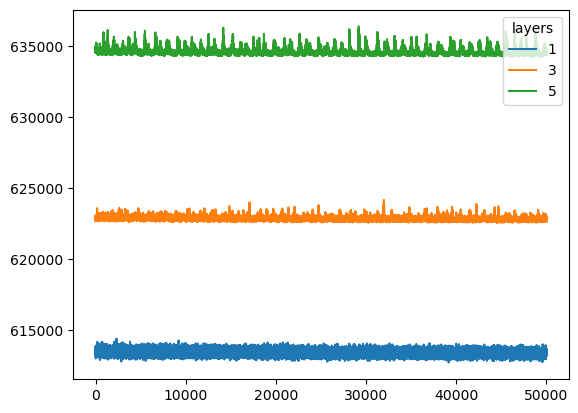

In [16]:
guide = delta_guide

for nh in num_hn[-3:-2]:
        for depth in range(1, 6, 2):
                print(depth, nh)
                rng_key, _rng_key = random.split(rng_key)
                dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

                optimizer = optax_to_numpyro(optax.adabelief(1e-3))
                svi = SVI(bayes_model, guide, optimizer, Trace_ELBO())

                rng_key, _rng_key = random.split(rng_key)
                results = svi.run(_rng_key, 100000, dense_net, train_ds['image'], labels=train_ds['label'], subsample_size=1024);

                rng_key, _rng_key = random.split(rng_key)
                test_model(rng_key, bayes_model, results.params, dense_net, test_ds['image'], test_ds['label'], guide=guide)

                plt.plot(results.losses[-50000:], label=depth)

plt.legend(title="layers");

In [20]:
from functools import partial
from jax import grad, jvp, hessian

from numpyro.infer.util import log_density
import jax.tree_util as jtu

def log_joint(nnet, data_set, treedef, leaves):
    
    n, _ = data_set['image'].shape
    model_args = (nnet, data_set['image'])
    model_kwargs = {
        'labels': data_set['label'],
        'subsample_size': 1000
    }

    values = jtu.tree_unflatten(treedef, leaves)
    params = {}
    for key in values:
        name = key.split('_')[-1]
        params[name] = values[key]

    with handlers.seed(rng_seed=0):
        log_joint, _ = log_density(bayes_model, model_args, model_kwargs, params)

    return log_joint

def local_log_joint(dict, key, value):
    dict[key] = value
    par_vals, treedef = jtu.tree_flatten(dict)
    return log_joint(dense_net, train_ds, treedef, par_vals)

H = {}
for key in results.params:
    tmp = results.params.copy()
    tmp.pop(key)
    value = results.params[key]
    local_lj = partial(local_log_joint, tmp, key)
    tangent = jnp.ones_like(value)
    H[key] = jvp( grad(local_lj), (value,), (tangent,))[1]

1 80


100%|██████████| 100000/100000 [05:48<00:00, 286.55it/s, init loss: 956456.6875, avg. loss [95001-100000]: 585614.3750]


0.66588 0.022475848
3 80


100%|██████████| 100000/100000 [07:31<00:00, 221.41it/s, init loss: 751032.7500, avg. loss [95001-100000]: 576821.6875]


0.45185 0.008185872
5 80


100%|██████████| 100000/100000 [09:13<00:00, 180.79it/s, init loss: 748992.4375, avg. loss [95001-100000]: 587561.1875]


0.19572 0.005285224


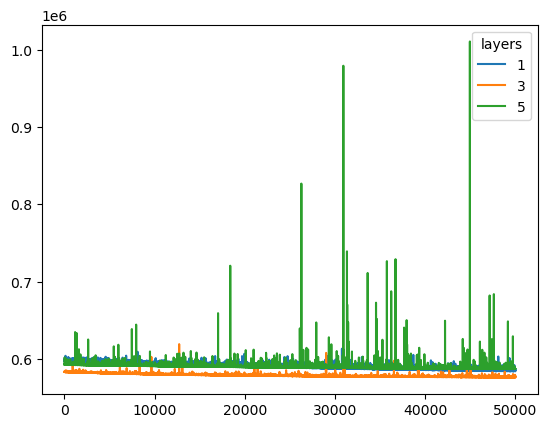

In [20]:
guide = normal_guide

for nh in num_hn[-3:-2]:
        for depth in range(1, 6, 2):
                print(depth, nh)
                rng_key, _rng_key = random.split(rng_key)
                dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

                optimizer = optax_to_numpyro(optax.adabelief(1e-4))
                svi = SVI(bayes_model, guide, optimizer, TraceMeanField_ELBO(num_particles=10))

                rng_key, _rng_key = random.split(rng_key)
                results = svi.run(_rng_key, 100000, dense_net, train_ds['image'], labels=train_ds['label'], subsample_size=1024);

                rng_key, _rng_key = random.split(rng_key)
                test_model(rng_key, bayes_model, results.params, dense_net, test_ds['image'], test_ds['label'], guide=guide, num_samples=10)

                plt.plot(results.losses[-50000:], label=depth)

plt.legend(title="layers");

1 200


100%|██████████| 100000/100000 [10:36<00:00, 157.08it/s, init loss: 5236767232.0000, avg. loss [95001-100000]: -357731808.0000]


0.10414999 0.0035654597
3 200


  0%|          | 0/100000 [00:00<?, ?it/s]/home/dima/.conda/envs/numpc/lib/python3.10/site-packages/jax/linear_util.py:168: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'layer2.c^2', 'layer1.c^2', 'layer0.c^2', 'layer3.c^2'}
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 100000/100000 [16:23<00:00, 101.69it/s, init loss: 63411320782848.0000, avg. loss [95001-100000]: -831664394918979417669632.0000]


0.1 7.450581e-09
5 200


  0%|          | 0/100000 [00:00<?, ?it/s]/home/dima/.conda/envs/numpc/lib/python3.10/site-packages/jax/linear_util.py:168: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'layer0.c^2', 'layer1.c^2', 'layer4.c^2', 'layer2.c^2', 'layer5.c^2', 'layer3.c^2'}
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 100000/100000 [22:35<00:00, 73.80it/s, init loss: 329123137734049792.0000, avg. loss [95001-100000]: -493040396261654695772160.0000]


0.1 7.450581e-09


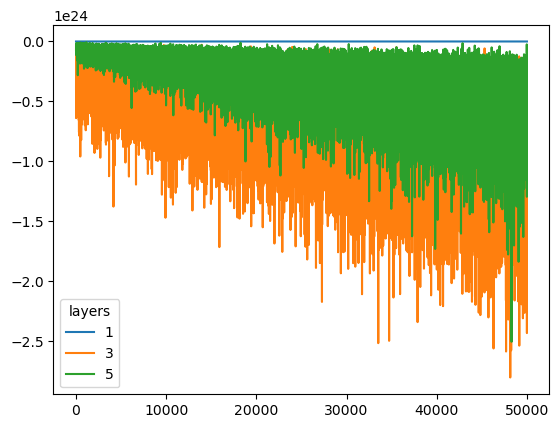

In [21]:
guide = partial(lowrank_guide, 2)

for nh in num_hn[-1:]:
        for depth in range(1, 6, 2):
                print(depth, nh)
                rng_key, _rng_key = random.split(rng_key)
                dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

                optimizer = optax_to_numpyro(optax.adabelief(1e-3))
                svi = SVI(bayes_model, guide, optimizer, Trace_ELBO(num_particles=10))

                rng_key, _rng_key = random.split(rng_key)
                results = svi.run(_rng_key, 100000, dense_net, train_ds['image'], labels=train_ds['label'], subsample_size=1024);

                rng_key, _rng_key = random.split(rng_key)
                test_model(rng_key, bayes_model, results.params, dense_net, test_ds['image'], test_ds['label'], guide=guide, num_samples=10)

                plt.plot(results.losses[-50000:], label=depth)

plt.legend(title="layers");

## Bayesian model reduction for deep learning

Let us start with the following full generative model with normal priors over network parameters

\begin{equation}
    \begin{split}
        b_{li} &\sim \mathcal{N}\left(0, 1 \right) \\
        \omega_{lij} &\sim \mathcal{N}\left(0, 1 \right) \\
        y_n &\sim p\left(y| \pmb{W}, \pmb{X}_n  \right)
    \end{split}
\end{equation}

We look for the posterior in the form 
\begin{equation}
    \begin{split}
        p\left( \pmb{b}, \pmb{W}|\pmb{\mathcal{D}}\right) & \approx \prod_l q\left(\pmb{b}_l \right) \prod_i q\left( \pmb{W}_{li} \right)  \\
        q\left(\pmb{b}_l \right) &= \mathcal{N}\left(\pmb{\mu}_{l}^b, \pmb{\Sigma}_{l} \right) \\
        q\left( \pmb{W}_{li} \right) &= \mathcal{LR-N} \left( \pmb{\mu}_{li}^\omega, \pmb{\sigma}^2_{li}, \pmb{R}_{li}  \right)
    \end{split}
\end{equation}
where $\pmb{P}^{-1}_{li} = \pmb{\Sigma}_{li} = diag \left( \pmb{\sigma}^2_{li} \right) + \pmb{R}_{li}\pmb{R}_{li}^T $.

The reduced model introduces the following hierarchical prior over network weights

\begin{equation}
    \begin{split}
        c_l^2 &\sim \Gamma\left(2, 1 \right) \\
        \tau_{li} &\sim \mathcal{C}^{+}(0, 1) \\
        \lambda_{lij} &\sim \mathcal{C}^{+}(0, 1) \\
        \gamma^2_{lij} & = \frac{\tau^2_{li}\lambda^2_{lij}}{c_l^2 + \tau^2_{li}\lambda^2_{lij} } \\
        \omega_{lij} &\sim \mathcal{N}\left(0, \gamma^2_{lij} \right)
    \end{split}
\end{equation}

The change in the variational free energy is obtained as 

\begin{equation}
    \begin{split}
        \tilde{\pmb{\Sigma}}_{lk}^{-1} &= \tilde{\pmb{P}}_{lk} = \pmb{P}_{lk} + \pmb{G}^{-1}_{lk} - \pmb{I}_{K_{l-1}} \\
        \tilde{\pmb{\mu}}_{lk} &= \tilde{\pmb{\Sigma}}_{lk} \pmb{P}_{lk} \pmb{\mu}_{lk} \\
        \Delta F\left( \pmb{\gamma}_{lk} \right) &= \ln E_{q(\pmb{W})}\left[ \frac{\tilde{p}(\pmb{W}| \pmb{G})}{p(\pmb{W})}\right] \\
        &= \frac{1}{2} \ln |\pmb{G}_{lk}^{-1} \pmb{P}_{lk} \tilde{\pmb{\Sigma}}_{lk}| - \frac{1}{2}\left( \pmb{\mu}_{lk}^T \pmb{P}_{lk} \pmb{\mu}_{lk} - \tilde{\pmb{\mu}}_{lk}^T \tilde{\pmb{P}}_{lk}\tilde{\pmb{\mu}}_{lk}\right) \\
        \ln |\pmb{G}_{lk}^{-1} \pmb{P}_{lk} \tilde{\pmb{\Sigma}}_{lk}| & = - \ln | \pmb{G}_{lk}| - \ln |\pmb{\Sigma}_{lk}| + \ln |\tilde{\pmb{\Sigma}}_{lk}|    \\
        &= - \ln |\pmb{M}_{lk} | \\
        \tilde{\pmb{\mu}}_{lk}^T \tilde{\pmb{P}}_{lk}\tilde{\pmb{\mu}}_{lk} & = \pmb{\mu}_{lk}^T \pmb{P}_{lk} \tilde{\pmb{\Sigma}}_{lk} \pmb{P}_{lk} \pmb{\mu}_{lk} = \pmb{\mu}_{lk}^T \pmb{P}_{lk} \pmb{G}_{lk} \pmb{M}_{lk}^{-1} \pmb{\mu}_{lk}
    \end{split}
\end{equation}


where $ \pmb{G}_{lk} = diag(\pmb{\gamma}^2_{lk})$, and $\pmb{M}_{lk} = \pmb{G}_{lk} + \pmb{\Sigma}_{lk} \left( \pmb{I}_{K_{l-1}} - \pmb{G}_{lk} \right)$.

In [6]:
from models import BMRDNN

def test_model(rng_key, params, nnet, images, labels, num_samples=10, bmr=False):
    n, _ = images.shape
    rng_key, _rng_key = random.split(rng_key)
    bmrdn = BMRDNN(_rng_key, nnet, images, subsample_size=n)
    model = bmrdn.model
    if bmr:
        guide = bmrdn.mv_guide
    else:
        guide = bmrdn.lowrank_guide
    
    pred = Predictive(model, guide=guide, params=params, num_samples=num_samples)

    rng_key, _rng_key = random.split(rng_key)
    sample = pred(_rng_key)

    if num_samples > 1:
        acc = jnp.mean(sample['obs'] == labels, -1)
        print(acc.mean(), acc.std())
    else:
        print( jnp.mean(sample['obs'] == labels) )

In [9]:
for nh in num_hn[-1:]:
    for depth in [1]:
        print(depth, nh)
        rng_key, _rng_key = random.split(rng_key)
        dense_net = eqx.nn.MLP(in_size, out_size=out_size, width_size=nh, depth=depth, activation=nn.swish, key=_rng_key)

        rng_key, _rng_key = random.split(rng_key)
        bmr_dnn = BMRDNN(_rng_key, dense_net, train_ds['image'], subsample_size=512)

        params = bmr_dnn.fit(train_ds['label'], num_steps=50000, num_particles=16)
        
        rng_key, _rng_key = random.split(rng_key)
        test_model(rng_key, params, dense_net, test_ds['image'], test_ds['label'], num_samples=10)

1 200


100%|██████████| 50000/50000 [06:01<00:00, 138.49it/s, init loss: 2681106.5000, avg. loss [47501-50000]: 53758.9727] 


0.71699995 0.0032267696


In [13]:
devs = devices('gpu')

params = lax.stop_gradient(params)
bmr_res, samples = bmr_dnn.bmr(params, devs[1], num_samples=1, num_steps=1000, num_particles=4, opt_kwargs={'learning_rate': 1e-2})

for key in samples.keys():
    params[key] = lax.stop_gradient(samples[key].mean(0))

rng_key, _rng_key = random.split(rng_key)
test_model(rng_key, params, dense_net, test_ds['image'], test_ds['label'], num_samples=10, bmr=True)

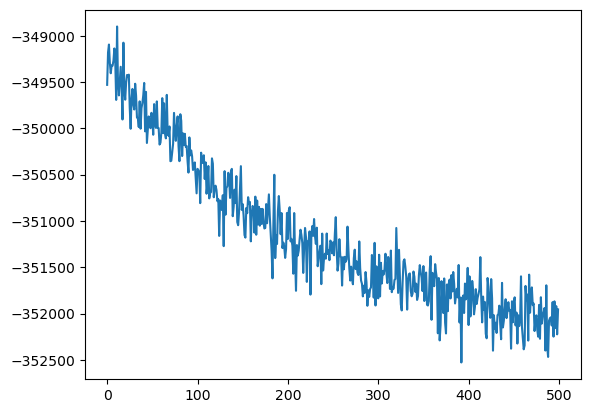

In [10]:
plt.plot(bmr_res.losses[-500:])

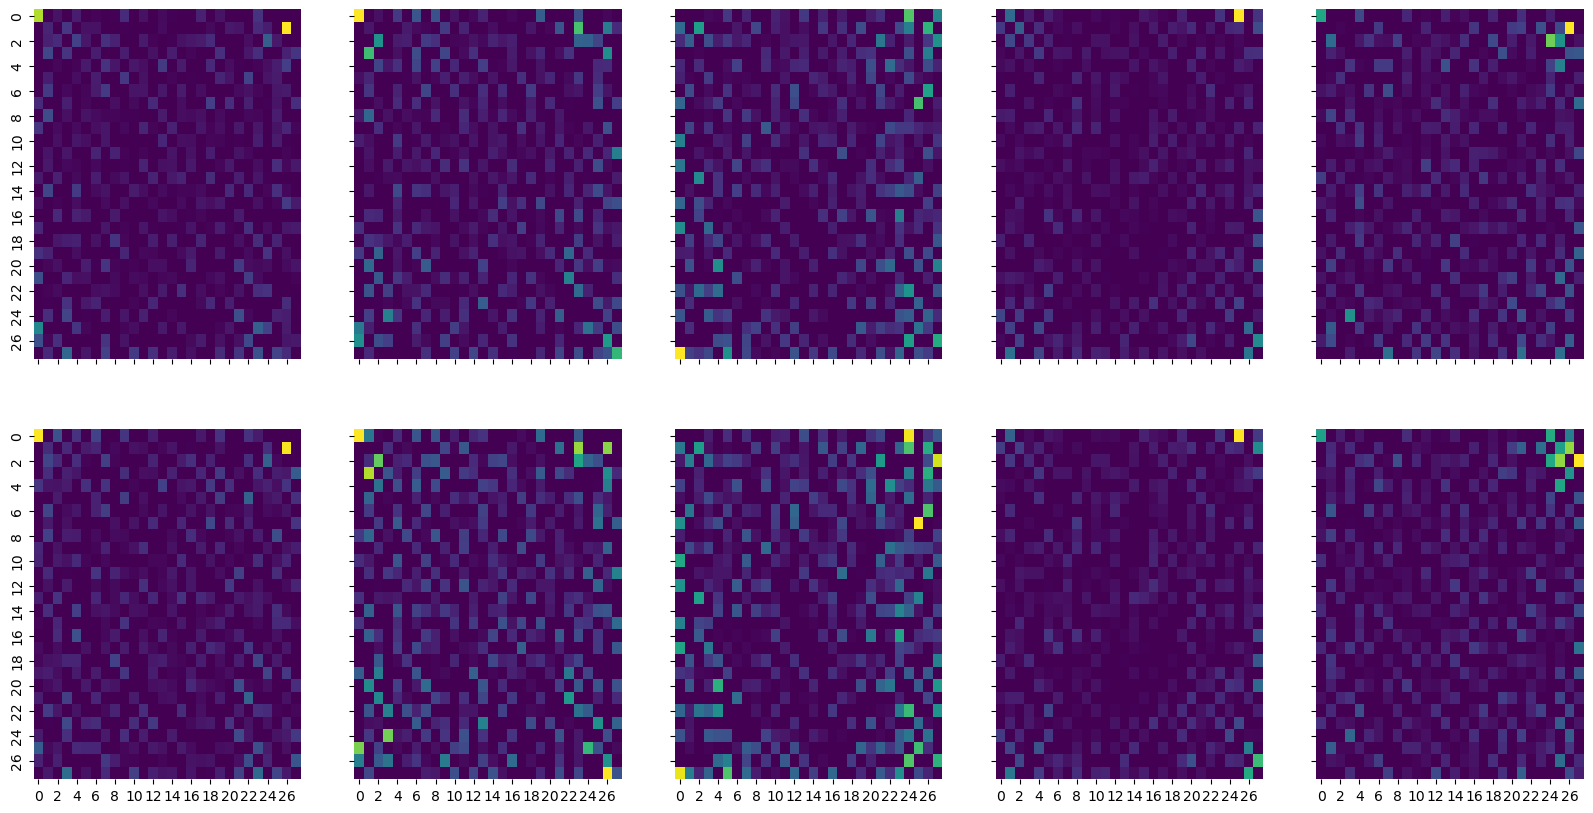

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True, sharex=True)

unweighten = jnp.linalg.inv(V @ jnp.diag(jnp.sqrt(W)))

weight = params['loc.layer0.weight'] @ unweighten
shrinked_weight = samples['layer0.weight.tilde_mu'].mean(0) @ unweighten

for i, ax in enumerate(axes[0]):
    sns.heatmap(weight[i].reshape(28, 28), ax=ax, cbar=False, cmap='viridis', vmin=0)
    sns.heatmap(shrinked_weight[i].reshape(28, 28), ax=axes[1, i], cbar=False, cmap='viridis', vmin=0)

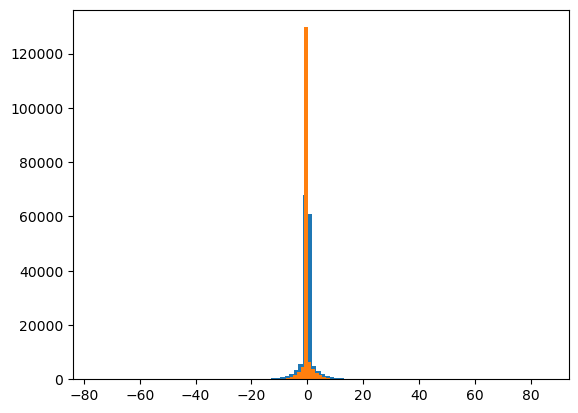

In [21]:
plt.hist(weight.flatten(), bins=100);
plt.hist(shrinked_weight.flatten(), bins=100);